In [71]:
import numpy as np
from sunpy.map import Map,GenericMap
import drms
import astropy.units as u
import astropy.time
from aiapy.response import Channel
from aiapy.response.util import get_correction_table
import copy
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SqrtStretch

%matplotlib inline

## Correcting a Single Map

In [58]:
c = drms.Client()

In [75]:
q = c.query('aia.lev1_euv_12s[2017-09-10T16:00:00/10s][171]',seg='image')

In [79]:
m_uncorrected = Map(q['image'][0])

In [80]:
c = Channel(m_uncorrected.wavelength)
degradation = c.time_correction(m_uncorrected.date)

In [81]:
m_corrected = m_uncorrected._new_instance(m_uncorrected.data / degradation,
                                          copy.deepcopy(m_uncorrected.meta))

In [86]:
m_diff = GenericMap(m_corrected.data - m_uncorrected.data,copy.deepcopy(m_corrected.meta))

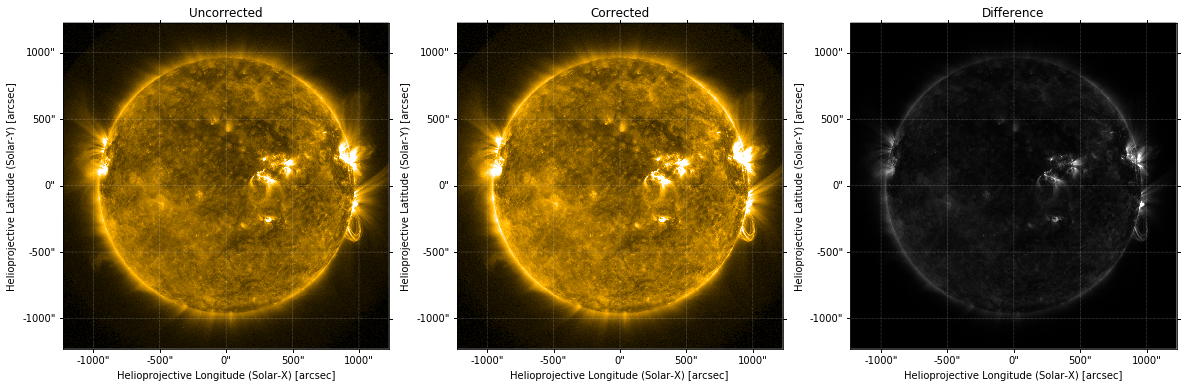

In [88]:
norm = ImageNormalize(vmin=0,vmax=1.5e3,stretch=SqrtStretch())
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(131,projection=m_uncorrected)
m_uncorrected.plot(axes=ax,title='Uncorrected',norm=norm)
ax = fig.add_subplot(132,projection=m_corrected)
m_corrected.plot(axes=ax,title='Corrected',norm=norm)
ax = fig.add_subplot(133,projection=m_diff)
m_diff.plot(axes=ax,title='Difference',vmin=0,vmax=1e3)

## Correcting Maps in Multiple Wavelengths

In [56]:
correction_table = get_correction_table()

In [57]:
def correct_degradation(smap):
    channel = Channel(smap.wavelength)
    degradation = channel.time_correction(smap.date,correction_table=correction_table)
    return smap._new_instance(smap.data / degradation,
                              copy.deepcopy(smap.meta))

In [65]:
q = c.query('aia.lev1_euv_12s[2016-01-08T09:00:00/10s][94,131,171,193,211,335]',seg='image')

In [66]:
maps_uncorrected = [Map(f) for f in q.values.tolist()]

In [67]:
maps_corrected = [correct_degradation(m) for m in maps_uncorrected]

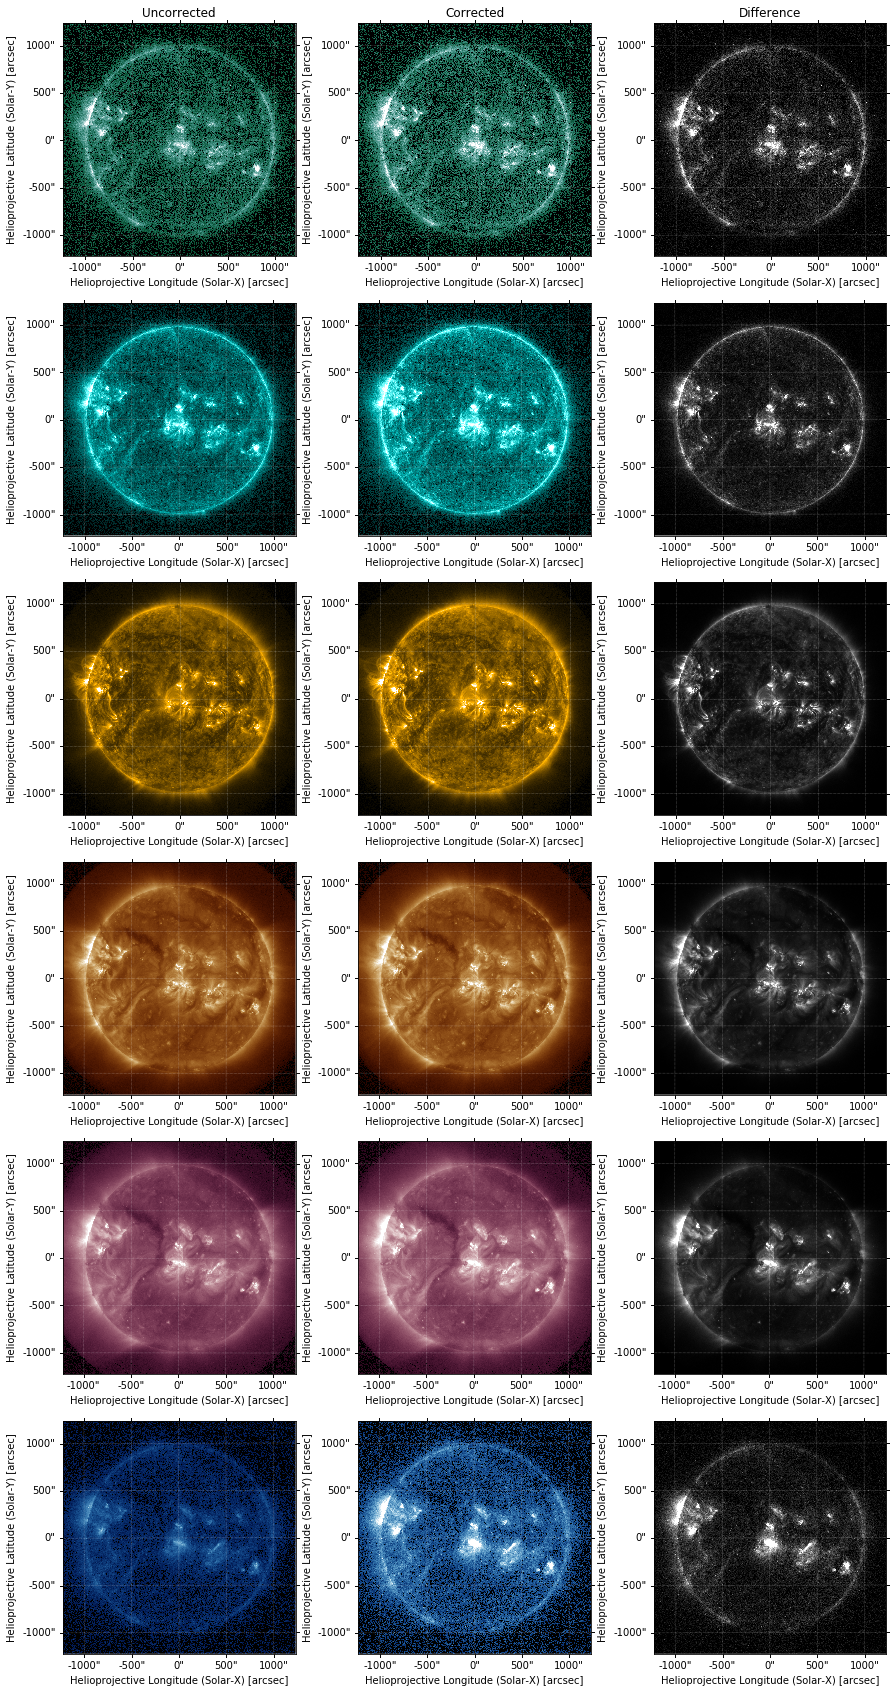

In [74]:
fig = plt.figure(figsize=(3*5,6*5))
for i,(mu,mc) in enumerate(zip(maps_uncorrected,maps_corrected)):
    norm = ImageNormalize(vmin=0,vmax=np.mean(mc.data)*10,stretch=SqrtStretch())
    ax = fig.add_subplot(6,3,3*i+1,projection=mu)
    mu.plot(norm=norm,axes=ax,title='Uncorrected' if i==0 else None)
    ax = fig.add_subplot(6,3,3*i+2,projection=mc)
    mc.plot(norm=norm,axes=ax,title='Corrected' if i==0 else None)
    m_diff = GenericMap(mc.data - mu.data,copy.deepcopy(mc.meta))
    ax = fig.add_subplot(6,3,3*i+3,projection=m_diff)
    m_diff.plot(axes=ax,title='Difference' if i==0 else None,vmin=0,vmax=np.mean(m_diff.data)*10)

## Correcting Maps over the Instrument Lifetime

Select 335 maps for several points over the lifetime of the instrument, correct them, and compare with the uncorrected maps. We'll select the 335 maps as those seem to have the worst degradation.

In [16]:
q = c.query('aia.lev1_euv_12s[2010-09-01T00:00:00/3285d@365d][335]',seg='image')

In [17]:
maps_uncorrected = [Map(f) for f in q.values.tolist()]

In [19]:
maps_corrected = [correct_degradation(m) for m in maps_uncorrected]

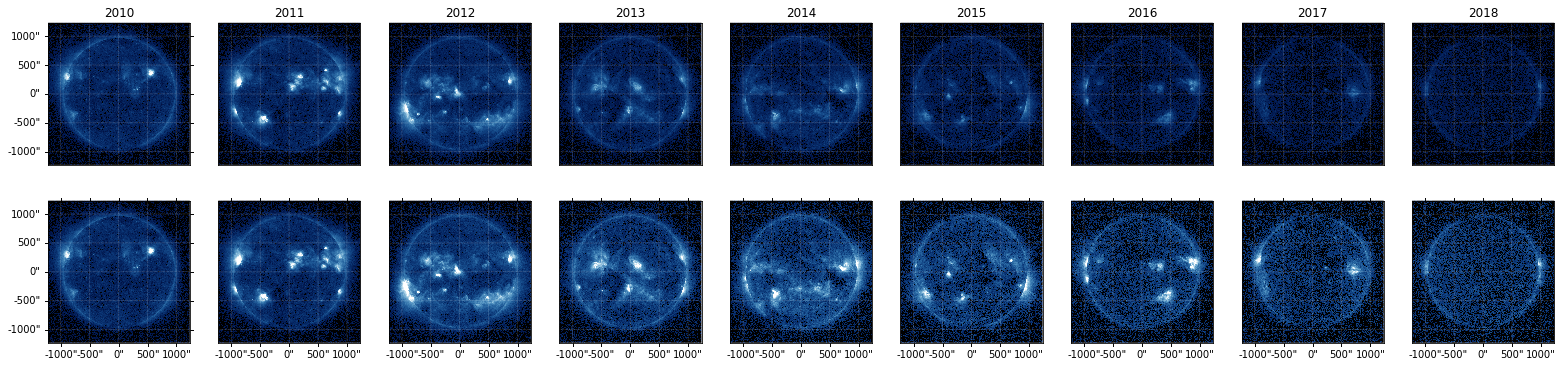

In [34]:
fig = plt.figure(figsize=(3*9,3*2))
for i,(mu,mc) in enumerate(zip(maps_uncorrected,maps_corrected)):
    ax = fig.add_subplot(2,9,i+1,projection=mu)
    mu.plot(axes=ax,norm=norm,annotate=False)
    ax.set_title(mu.date.datetime.year)
    lon,lat = ax.coords
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    if i > 0:
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)
    ax = fig.add_subplot(2,9,i+10,projection=mc)
    mc.plot(axes=ax,norm=norm,annotate=False,)
    lon,lat = ax.coords
    if i > 0:
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)

In [42]:
total_flux_uncorrected = u.Quantity([m.data.sum() for m in maps_uncorrected])
total_flux_corrected = u.Quantity([m.data.sum() for m in maps_corrected])

In [43]:
delta_t = u.Quantity([(m.date - maps_uncorrected[0].date).to(u.year) for m in maps_uncorrected])

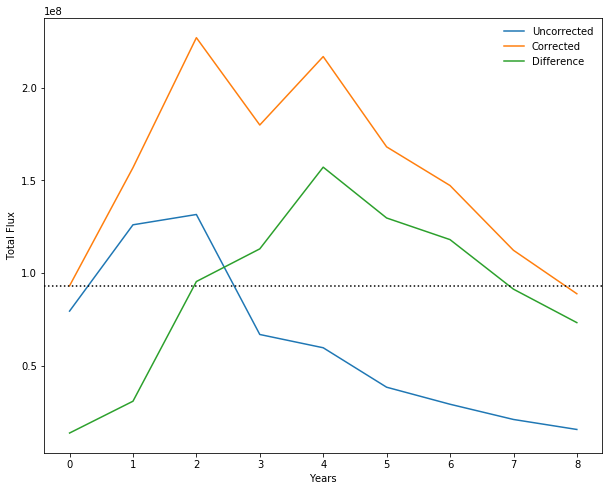

In [93]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.plot(delta_t,total_flux_uncorrected,label='Uncorrected')
ax.plot(delta_t,total_flux_corrected,label='Corrected')
ax.plot(delta_t, total_flux_corrected - total_flux_uncorrected,label='Difference')
ax.axhline(y=total_flux_corrected[0],ls=':',color='k')
ax.set_xlabel('Years')
ax.set_ylabel('Total Flux')
ax.legend(frameon=False)